In [1]:
import sys
import pickle
import glob
import os
import healpy as hp
import numpy as np
from matplotlib import pyplot as plt
import qubic
from qubic import AnalysisMC as amc
from qubic import QubicSkySim as qss
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
from qubic import AnalysisMC as amc

In [9]:
def read_maps_from_dict(map_file,constant_spectral_index=True,nbins_ring=25,compute_ang_noise= False):
    
    map_dict = pickle.load(open(map_file,'rb'))
    
    if constant_spectral_index:
        ncomps_out = map_dict['components_i'].shape[0]
        ncomps_in = map_dict['components'].shape[0]
        npix_tot = map_dict['components_i'].shape[1]
        nstokes = map_dict['components_i'].shape[2]
        comp_in = map_dict['components']
        comp_out = map_dict['components_i']
        residuals = comp_out - comp_in[:ncomps_out,:,:]
        seenpix = map_dict['seenpix']
    else:
        ncomps_out = map_dict['components_i'].shape[2]
        ncomps_in = map_dict['components'].shape[2]
        npix_tot = map_dict['components_i'].shape[1]
        nstokes = map_dict['components_i'].shape[0]
        comp_in = map_dict['components'].T
        comp_out = map_dict['components_i'].T
        residuals = comp_out - comp_in[:ncomps_out,:,:]
        seenpix = map_dict['seenpix']
    
    comp_out_qubicpatch = comp_out[:,map_dict['seenpix'],:]
    comp_in_qubicpatch = comp_in[:,map_dict['seenpix'],:]
    residuals_qubicpatch = residuals[:,map_dict['seenpix'],:]

    center = map_dict['center']
    # center_equ = map_dict['center']#[0,-57]
    # center_gal = qubic.equ2gal(center_equ[0], center_equ[1])
    
    nside = hp.npix2nside(npix_tot)
    pixsnum_seenpix = np.where(seenpix)[0]
    centralpix = hp.ang2pix(nside, center[0],center[1],lonlat=True)
    angmax= np.max( qss.get_angles(centralpix,pixsnum_seenpix,nside) )
    
    if compute_ang_noise:
        
        angs_int_dust,I_int_dust,Q_int_dust,U_int_dust,dI_int_dust,dQ_int_dust,dU_int_dust = get_angular_profile(residuals[1,:,:],thmax=angmax,nbins=1,doplot=False,allstokes=True,separate=True,integrated=True,center=center)
        angs_int_cmb,I_int_cmb,Q_int_cmb,U_int_cmb,dI_int_cmb,dQ_int_cmb,dU_int_cmb = get_angular_profile(residuals[0,:,:],thmax=angmax,nbins=1,doplot=False,allstokes=True,separate=True,integrated=True,center=center)

        residuals_angular_circles = np.array([[angs_int_cmb,I_int_cmb,Q_int_cmb,U_int_cmb,dI_int_cmb,dQ_int_cmb,dU_int_cmb],[angs_int_dust,I_int_dust,Q_int_dust,U_int_dust,dI_int_dust,dQ_int_dust,dU_int_dust]])

        angs_dust,I_dust,Q_dust,U_dust,dI_dust,dQ_dust,dU_dust = qss.get_angular_profile(residuals[1,:,:],thmax=30,nbins=nbins_ring,doplot=False,allstokes=True,separate=True,center=center)
        angs_cmb,I_cmb,Q_cmb,U_cmb,dI_cmb,dQ_cmb,dU_cmb = qss.get_angular_profile(residuals[0,:,:],thmax=30,nbins=nbins_ring,doplot=False,allstokes=True,separate=True,center=center)

        residuals_angular_rings = np.array([[angs_cmb,I_cmb,Q_cmb,U_cmb,dI_cmb,dQ_cmb,dU_cmb],[angs_dust,I_dust,Q_dust,U_dust,dI_dust,dQ_dust,dU_dust]])

        return comp_out_qubicpatch, comp_in_qubicpatch, residuals_qubicpatch, residuals_angular_circles, residuals_angular_rings, angmax, residuals, seenpix, nside, center

    else:
        
        return comp_out, comp_in, residuals, nside, seenpix, angmax, center        

sys.path.insert(1,"/home/nahue-ofi/CMM-Pipeline/src")
# sys.path.insert(1,"/home/nahue/CMM-Pipeline/src")

from simtools.analysis import get_angular_profile

In [4]:
# # thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# # thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# # thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
# # thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'
# # thedir = '/home/nahue-ofi/heavy-data/realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two'
# # thedir = '/home/nahue-ofi/heavy-data/forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two'

# # thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_30_44_70_planck_parametric_d0_two'
# # thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_100_143_planck_parametric_d0_two'
# # thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two'


# dic_name = '*file*'
# realizations = np.sort(glob.glob(thedir + '/' + dic_name))

# # for i in range(len(realizations)):
# #     print(i, realizations[i])

# # realizations = realizations[:30]

# nreals = len(realizations)

# print(nreals)

In [6]:
# base_dir = '/media/nahue/files_hdd/heavy-data/cmm-results/'
base_dir = '/home/nahue-ofi/heavy-data/'

different_bands = ['cmb_d0_30_44_70_planck_parametric_d0_two', 'cmb_d0_100_143_planck_parametric_d0_two',
                    'cmb_d0_217_353_planck_parametric_d0_two', 'cmb_d0_fullHFI_planck_parametric_d0_two']

for j, dif_band in enumerate(different_bands):

    realizations = np.sort(glob.glob(base_dir+dif_band+'/'+'**'))

    nreals = len(realizations)

    print(nreals)
      
    constant_spectral_index = True
    
    nbins_ring = 35

    angs_cmb = np.zeros((nreals,nbins_ring))
    Q_cmb = np.zeros((nreals,nbins_ring))
    U_cmb = np.zeros((nreals,nbins_ring))
    dQ_cmb = np.zeros((nreals,nbins_ring))
    dU_cmb = np.zeros((nreals,nbins_ring))
    angs_dust = np.zeros((nreals,nbins_ring))
    Q_dust = np.zeros((nreals,nbins_ring))
    U_dust = np.zeros((nreals,nbins_ring))
    dQ_dust = np.zeros((nreals,nbins_ring))
    dU_dust = np.zeros((nreals,nbins_ring))

    Q_cmb_int = np.zeros(nreals)
    U_cmb_int = np.zeros(nreals)
    dQ_cmb_int = np.zeros(nreals)
    dU_cmb_int = np.zeros(nreals)
    Q_dust_int = np.zeros(nreals)
    U_dust_int = np.zeros(nreals)
    dQ_dust_int = np.zeros(nreals)
    dU_dust_int = np.zeros(nreals)

    for i,map_file in enumerate(realizations):
        comp_out_qubicpatch, comp_in_qubicpatch, residuals_qubicpatch, residuals_angular_circles, residuals_angular_rings, angmax, residuals, seenpix, nside, center = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring,compute_ang_noise=True)
        angs_cmb[i,:] = residuals_angular_rings[0,0]
        Q_cmb[i,:] = residuals_angular_rings[0,2]
        U_cmb[i,:] = residuals_angular_rings[0,3]
        dQ_cmb[i,:] = residuals_angular_rings[0,5]
        dU_cmb[i,:] = residuals_angular_rings[0,6]
        angs_dust[i,:] = residuals_angular_rings[1,0]
        Q_dust[i,:] = residuals_angular_rings[1,2]
        U_dust[i,:] = residuals_angular_rings[1,3]
        dQ_dust[i,:] = residuals_angular_rings[1,5]
        dU_dust[i,:] = residuals_angular_rings[1,6]

        Q_cmb_int[i] = residuals_angular_circles[0,2][0]
        U_cmb_int[i] = residuals_angular_circles[0,3][0]
        dQ_cmb_int[i] = residuals_angular_circles[0,5][0]
        dU_cmb_int[i] = residuals_angular_circles[0,6][0]
        Q_dust_int[i] = residuals_angular_circles[1,2][0]
        U_dust_int[i] = residuals_angular_circles[1,3][0]
        dQ_dust_int[i] = residuals_angular_circles[1,5][0]
        dU_dust_int[i] = residuals_angular_circles[1,6][0]

    results = {}
    results['angs_cmb'] = angs_cmb
    results['dQ_cmb'] = dQ_cmb
    results['dU_cmb'] = dU_cmb
    results['Q_cmb'] = Q_cmb
    results['U_cmb'] = U_cmb
    results['angs_dust'] = angs_dust
    results['dQ_dust'] = dQ_dust
    results['dU_dust'] = dU_dust
    results['Q_dust'] = Q_dust
    results['U_dust'] = U_dust
    results['dQ_cmb_int'] = dQ_cmb_int
    results['dU_cmb_int']= dU_cmb_int
    results['dQ_dust_int'] = dQ_dust_int
    results['dU_dust_int'] = dU_dust_int 
    results['Q_cmb_int'] = Q_cmb_int
    results['U_cmb_int']= U_cmb_int
    results['Q_dust_int'] = Q_dust_int
    results['U_dust_int'] = U_dust_int 
    results['angmax'] = angmax
#     results['seenpix'] = seenpix
#     results['residuals'] = res
    
    np.save(dif_band, results)

99
99
99
99


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

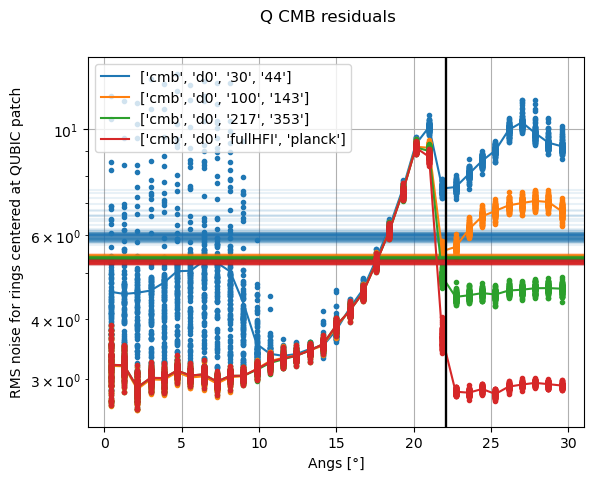

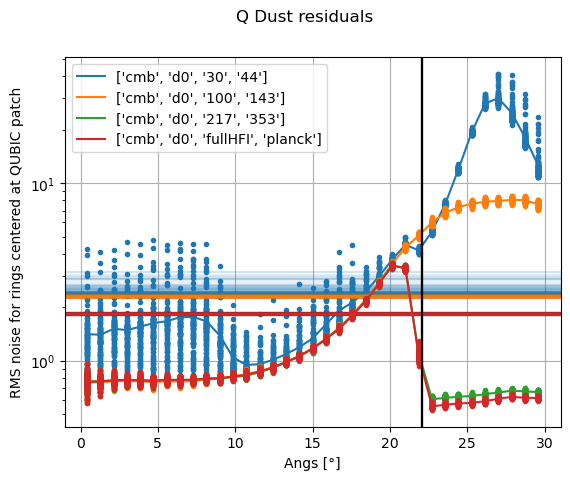

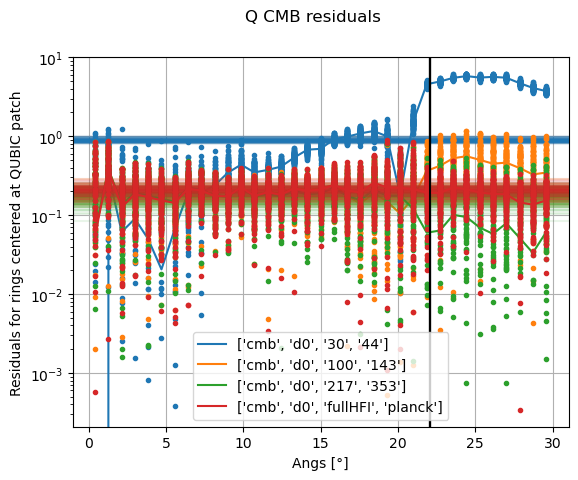

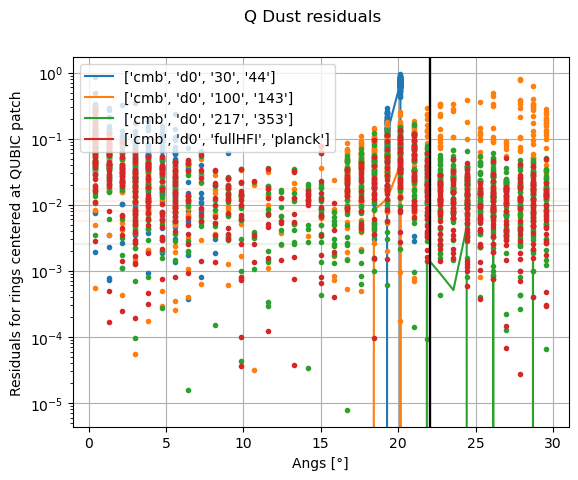

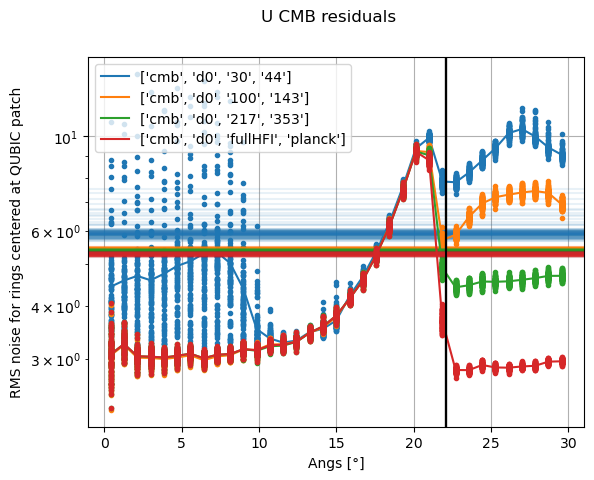

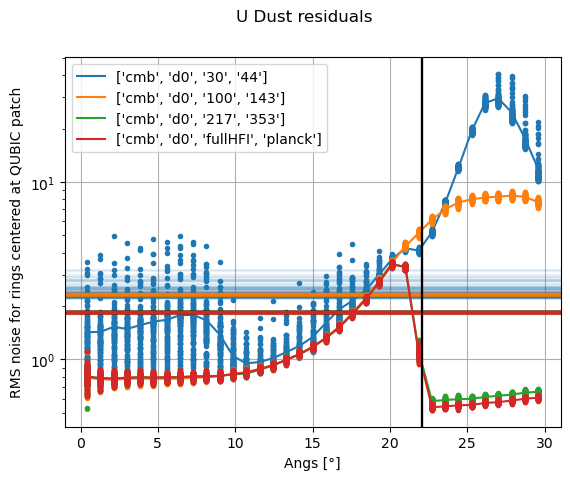

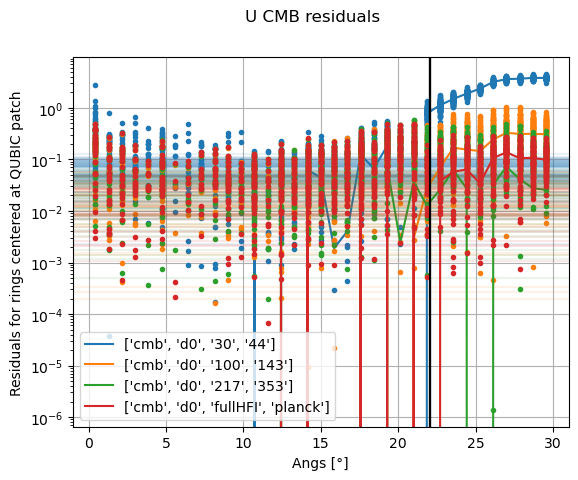

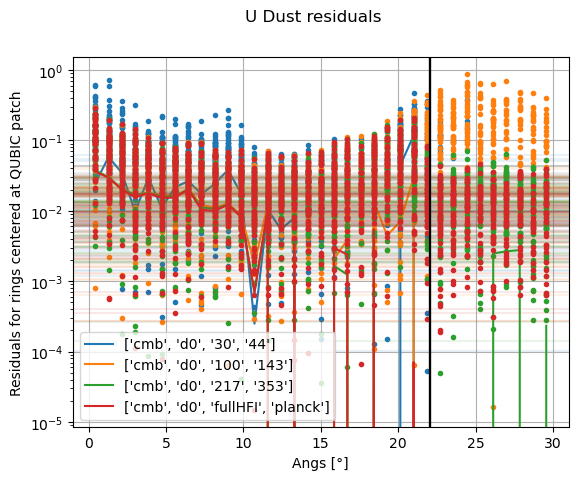

In [11]:
for j, dif_band in enumerate(different_bands):
    
    results_dict = np.load(dif_band+'.npy',allow_pickle=True).item()

    angs_cmb = results_dict['angs_cmb'] 
    dQ_cmb = results_dict['dQ_cmb'] 
    dU_cmb = results_dict['dU_cmb'] 
    Q_cmb = results_dict['Q_cmb'] 
    U_cmb = results_dict['U_cmb'] 
    angs_dust = results_dict['angs_dust'] 
    dQ_dust = results_dict['dQ_dust'] 
    dU_dust = results_dict['dU_dust'] 
    Q_dust = results_dict['Q_dust'] 
    U_dust = results_dict['U_dust'] 
    dQ_cmb_int = results_dict['dQ_cmb_int'] 
    dU_cmb_int = results_dict['dU_cmb_int']
    dQ_dust_int = results_dict['dQ_dust_int'] 
    dU_dust_int = results_dict['dU_dust_int']
    Q_cmb_int = results_dict['Q_cmb_int'] 
    U_cmb_int = results_dict['U_cmb_int']
    Q_dust_int = results_dict['Q_dust_int'] 
    U_dust_int = results_dict['U_dust_int'] 
    angmax = results_dict['angmax']
    
    plt.figure(1)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_cmb[i,:],dQ_cmb[i,:],'.',c=f'C{j}')
        plt.axhline(dQ_cmb_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_cmb[0,:],np.mean(dQ_cmb,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(2)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_dust[i,:],dQ_dust[i,:],'.',c=f'C{j}')
        plt.axhline(dQ_dust_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_dust[0,:],np.mean(dQ_dust,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(3)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_cmb[i,:],Q_cmb[i,:],'.',c=f'C{j}')
        plt.axhline(Q_cmb_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_cmb[0,:],np.mean(Q_cmb,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(4)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_dust[i,:],Q_dust[i,:],'.',c=f'C{j}')
        plt.axhline(Q_dust_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_dust[0,:],np.mean(Q_dust,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')
    
    plt.figure(5)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_cmb[i,:],dU_cmb[i,:],'.',c=f'C{j}')
        plt.axhline(dU_cmb_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_cmb[0,:],np.mean(dU_cmb,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(6)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_dust[i,:],dU_dust[i,:],'.',c=f'C{j}')
        plt.axhline(dU_dust_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_dust[0,:],np.mean(dU_dust,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(7)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_cmb[i,:],U_cmb[i,:],'.',c=f'C{j}')
        plt.axhline(U_cmb_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_cmb[0,:],np.mean(U_cmb,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')

    plt.figure(8)
    for i in range(len(angs_cmb[:,0])):
        plt.plot(angs_dust[i,:],U_dust[i,:],'.',c=f'C{j}')
        plt.axhline(U_dust_int[i],c=f'C{j}',alpha=0.1)
    plt.plot(angs_dust[0,:],np.mean(U_dust,axis=0),c=f'C{j}',label=dif_band.split('_')[:4])
    plt.axvline(angmax,c='k')
    
plt.figure(1)
plt.suptitle('Q CMB residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(2)
plt.suptitle('Q Dust residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(3)
plt.suptitle('Q CMB residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('Residuals for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(4)
plt.suptitle('Q Dust residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('Residuals for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(5)
plt.suptitle('U CMB residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(6)
plt.suptitle('U Dust residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(7)
plt.suptitle('U CMB residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('Residuals for rings centered at QUBIC patch')
plt.tight_layout

plt.figure(8)
plt.suptitle('U Dust residuals')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Angs [°]')
plt.ylabel('Residuals for rings centered at QUBIC patch')
plt.tight_layout

(6, 6, 26381)


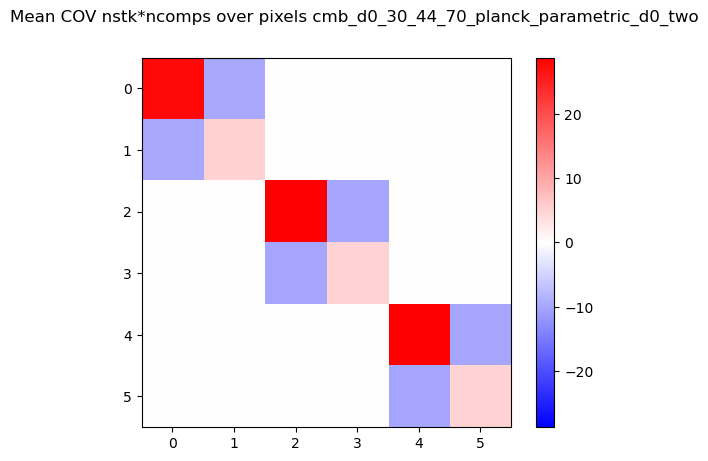

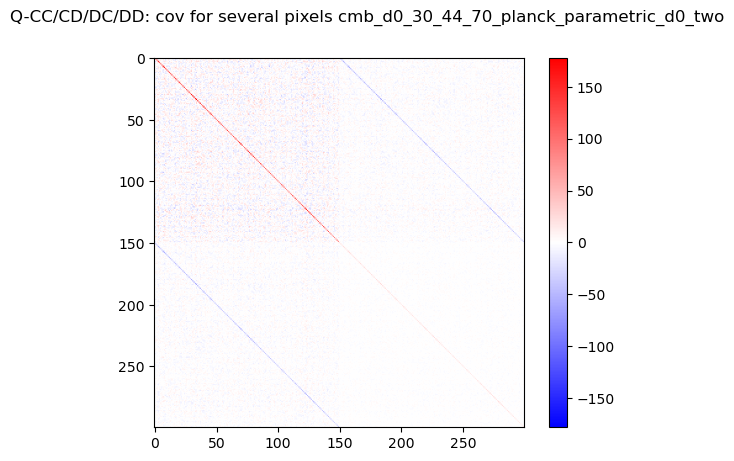

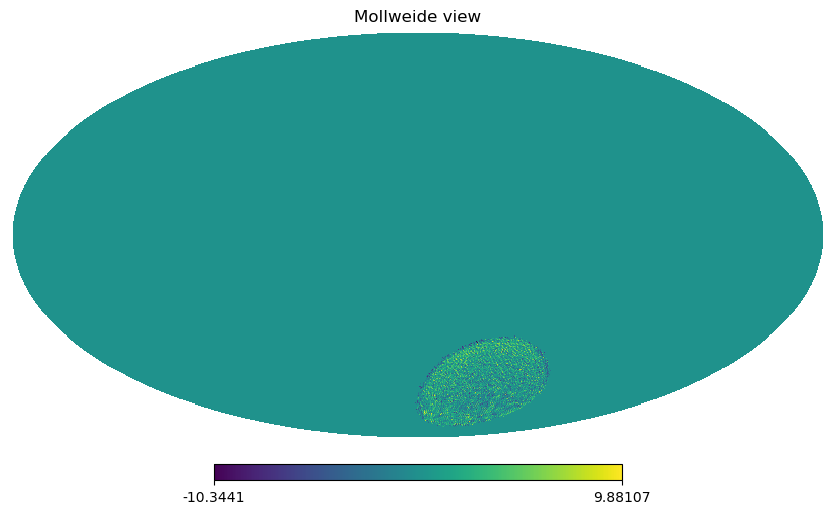

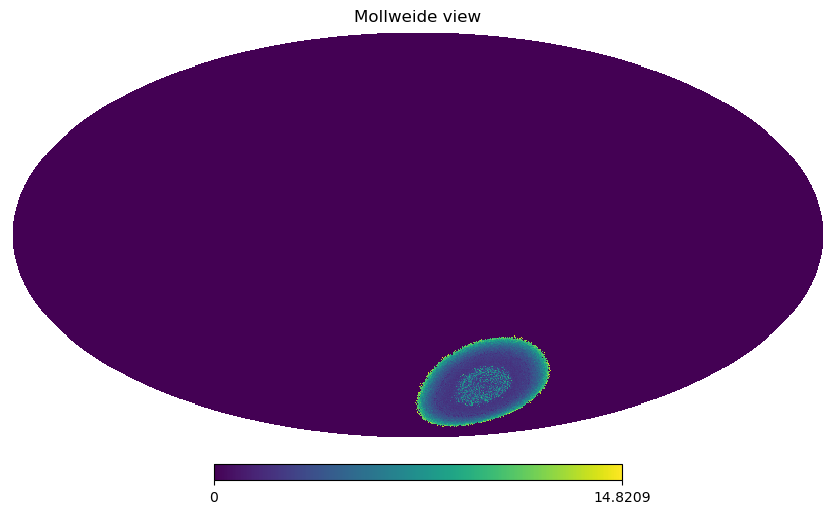

In [12]:
thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'

# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two'

realizations = np.sort(glob.glob(thedir+'/'+'**'))

nreals = len(realizations)

res = []

for i,map_file in enumerate(realizations):

    comp_out, comp_in, residuals, nside, seenpix, angmax, center = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring)

    res.append(residuals)

res = np.array(res)

res_qubic = res[:,:,seenpix,:]

cov, corr = amc.get_covcorr_patch(res_qubic,stokesjoint=True)

print(cov.shape)

cov = np.mean(cov[:, :, :],axis=2)
corr = np.mean(corr[:, :, :],axis=2)

plt.figure()

plt.suptitle('Mean COV nstk*ncomps over pixels ' + thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov(res_qubic[:,0,50:200,1],res_qubic[:,1,50:200,1],rowvar=False)

plt.figure()
plt.suptitle('Q-CC/CD/DC/DD: cov for several pixels '+ thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[seenpix] = 1

masked_res = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res[i,:] = mask * res[i,0,:,1]

masked_mean_res = mask*np.mean(res[:,0,:,1],axis=0)

hp.mollview(masked_mean_res)
hp.mollview(np.std(masked_res,axis=0))

(6, 6, 26381)


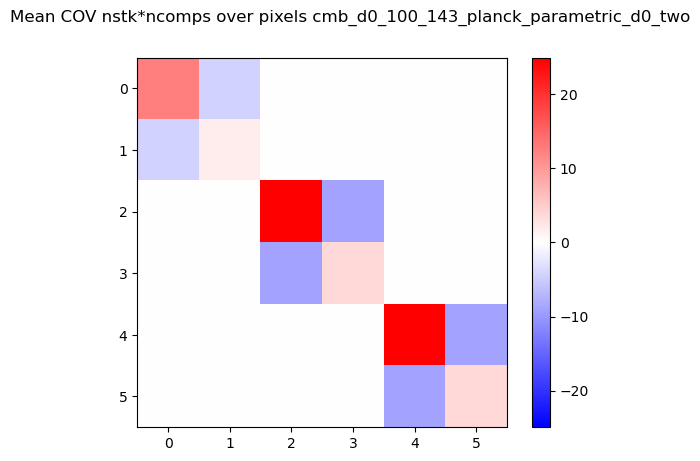

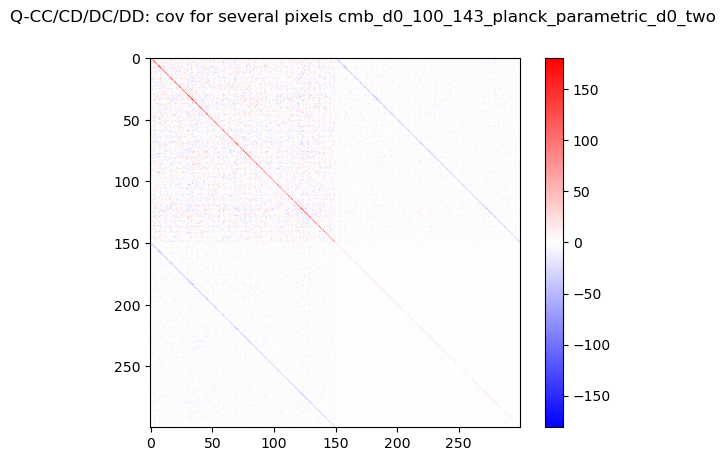

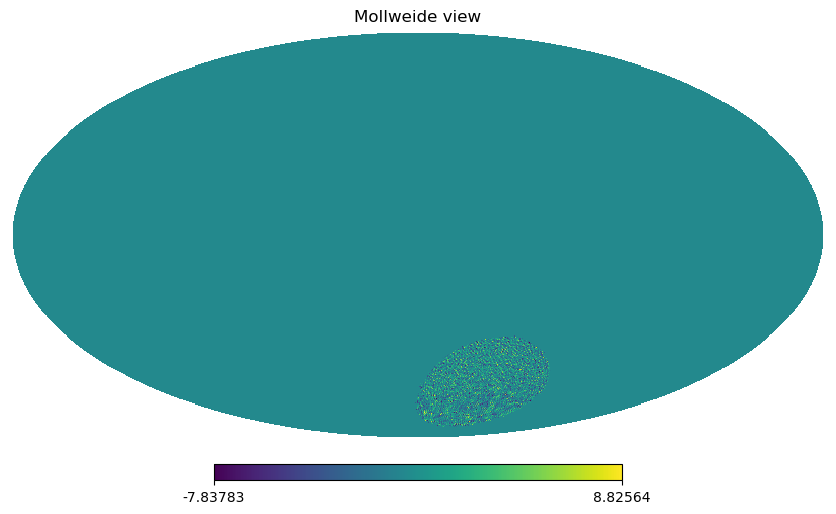

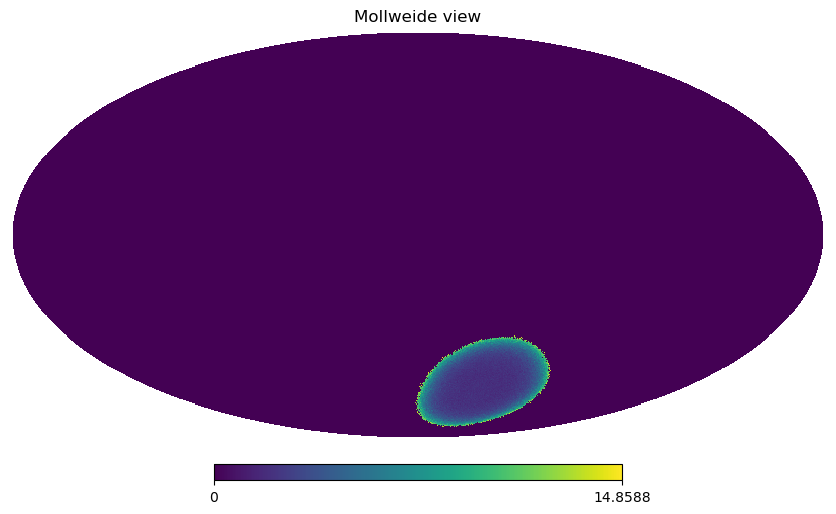

In [13]:
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'

# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two'

realizations = np.sort(glob.glob(thedir+'/'+'**'))

nreals = len(realizations)

res = []

for i,map_file in enumerate(realizations):

    comp_out, comp_in, residuals, nside, seenpix, angmax = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring)

    res.append(residuals)

res = np.array(res)

res_qubic = res[:,:,seenpix,:]

cov, corr = amc.get_covcorr_patch(res_qubic,stokesjoint=True)

print(cov.shape)

cov = np.mean(cov[:, :, :],axis=2)
corr = np.mean(corr[:, :, :],axis=2)

plt.figure()

plt.suptitle('Mean COV nstk*ncomps over pixels ' + thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov(res_qubic[:,0,50:200,1],res_qubic[:,1,50:200,1],rowvar=False)

plt.figure()
plt.suptitle('Q-CC/CD/DC/DD: cov for several pixels '+ thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[seenpix] = 1

masked_res = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res[i,:] = mask * res[i,0,:,1]

masked_mean_res = mask*np.mean(res[:,0,:,1],axis=0)

hp.mollview(masked_mean_res)
hp.mollview(np.std(masked_res,axis=0))

(6, 6, 26381)


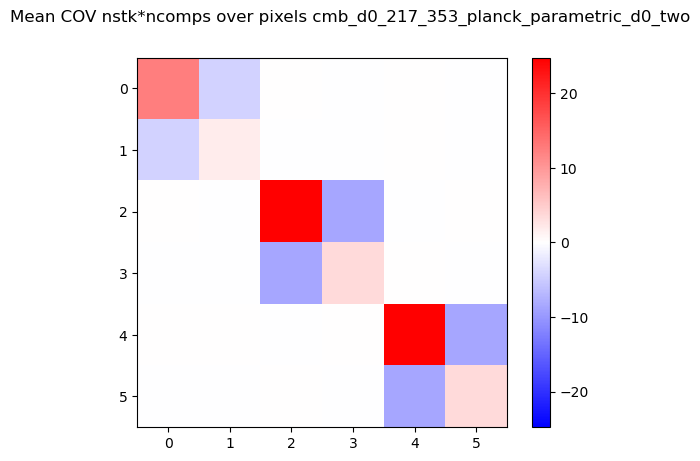

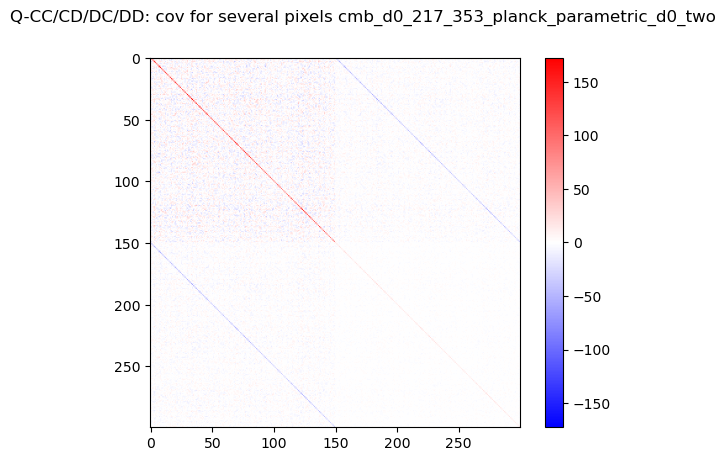

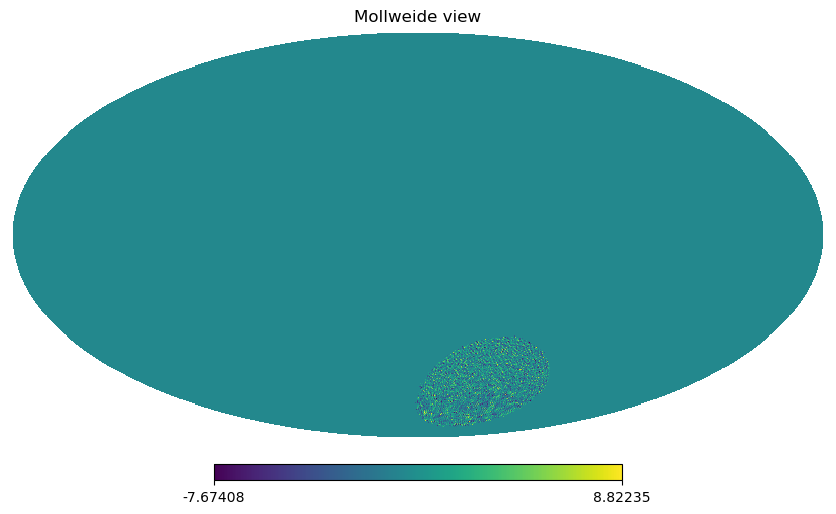

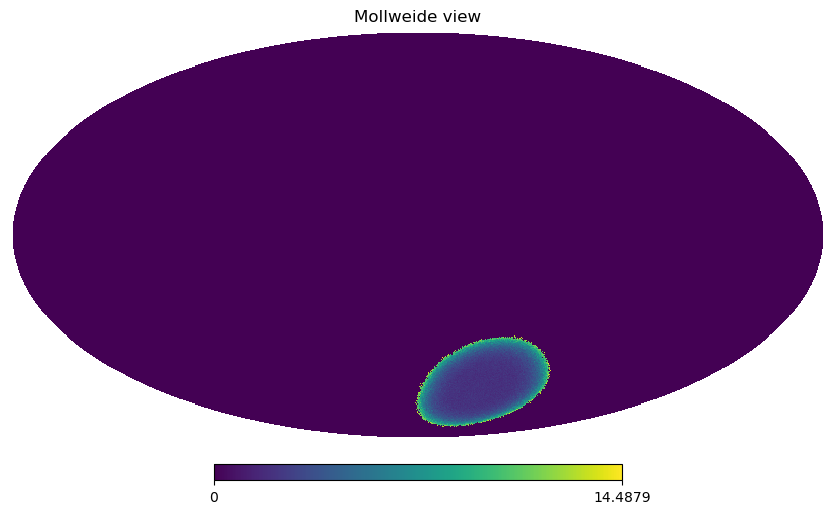

In [14]:
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'

# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two'

realizations = np.sort(glob.glob(thedir+'/'+'**'))

nreals = len(realizations)

res = []

for i,map_file in enumerate(realizations):

    comp_out, comp_in, residuals, nside, seenpix, angmax = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring)

    res.append(residuals)

res = np.array(res)

res_qubic = res[:,:,seenpix,:]

cov, corr = amc.get_covcorr_patch(res_qubic,stokesjoint=True)

print(cov.shape)

cov = np.mean(cov[:, :, :],axis=2)
corr = np.mean(corr[:, :, :],axis=2)

plt.figure()

plt.suptitle('Mean COV nstk*ncomps over pixels ' + thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov(res_qubic[:,0,50:200,1],res_qubic[:,1,50:200,1],rowvar=False)

plt.figure()
plt.suptitle('Q-CC/CD/DC/DD: cov for several pixels '+ thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[seenpix] = 1

masked_res = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res[i,:] = mask * res[i,0,:,1]

masked_mean_res = mask*np.mean(res[:,0,:,1],axis=0)

hp.mollview(masked_mean_res)
hp.mollview(np.std(masked_res,axis=0))

(6, 6, 26381)
540


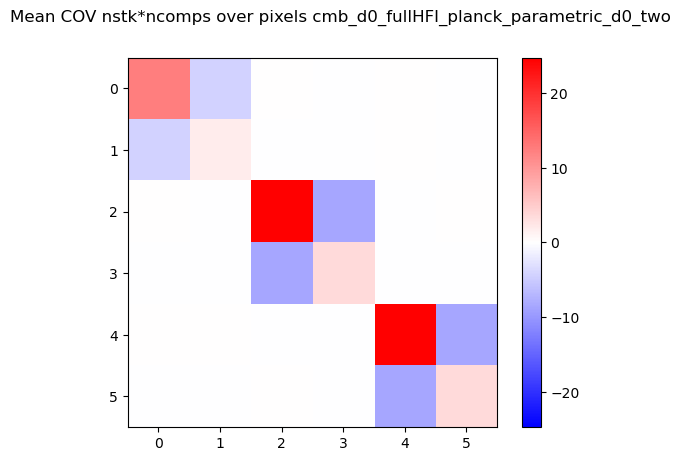

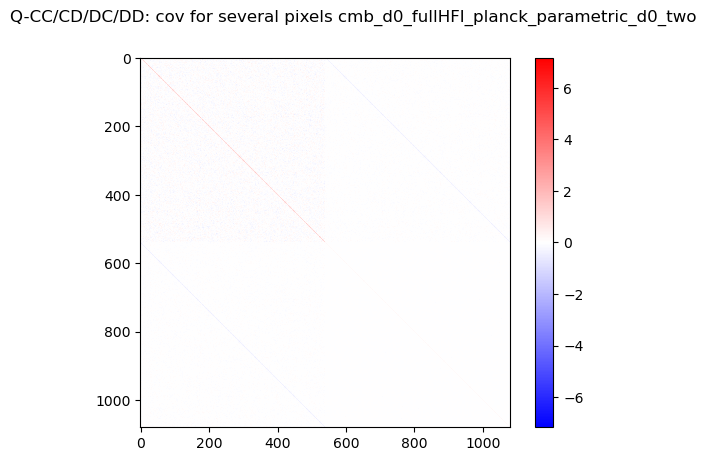

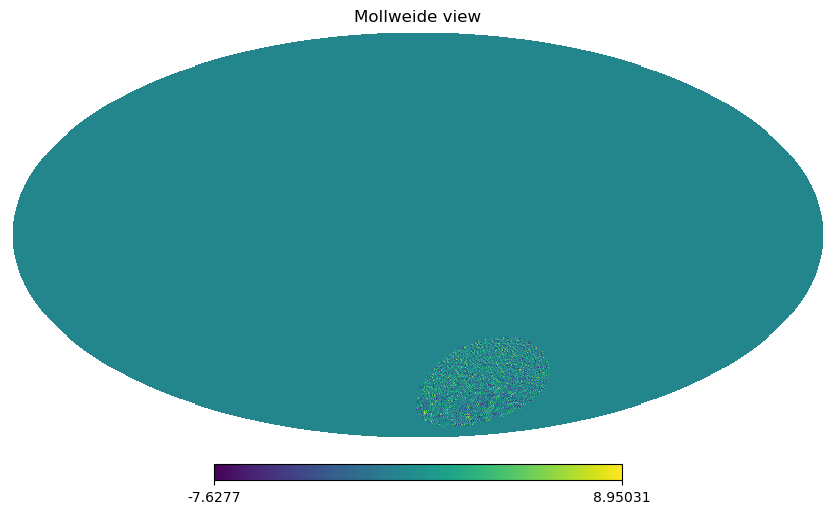

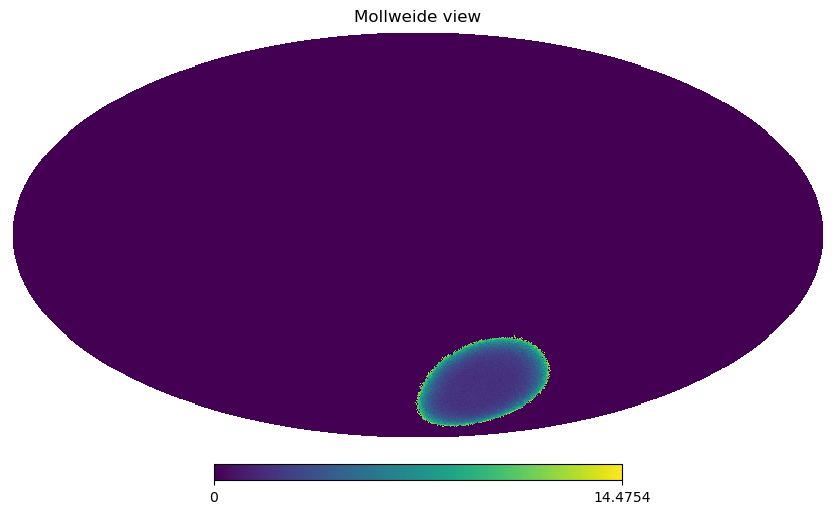

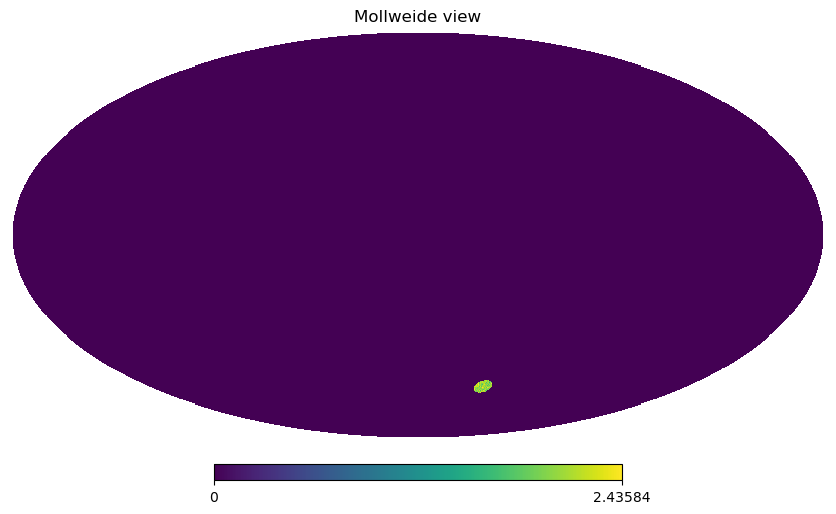

In [27]:
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'

# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/media/nahue/files_hdd/heavy-data/cmm-results/cmb_d0_fullHFI_planck_parametric_d0_two'

realizations = np.sort(glob.glob(thedir+'/'+'**'))

nreals = len(realizations)

res = []

for i,map_file in enumerate(realizations):

    comp_out, comp_in, residuals, nside, seenpix, angmax, center = read_maps_from_dict(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring)

    res.append(residuals)

res = np.array(res)

res_qubic = res[:,:,seenpix,:]

cov, corr = amc.get_covcorr_patch(res_qubic,stokesjoint=True)

print(cov.shape)

cov = np.mean(cov[:, :, :],axis=2)
corr = np.mean(corr[:, :, :],axis=2)

plt.figure()

plt.suptitle('Mean COV nstk*ncomps over pixels ' + thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

centralvec = hp.ang2vec(center[0],center[1],lonlat=True)
radius_for_disc = np.deg2rad(3) #input in degree, output in rad
pixs_in_disc = hp.query_disc(nside, centralvec, radius_for_disc)
print(len(pixs_in_disc))

npix_disc = hp.nside2npix(nside)
seenpix_inner_disc = np.zeros(npix)
for i in pixs_in_disc:
    seenpix_inner_disc[i] = 1
seenpix_inner_disc = np.array(seenpix_inner_disc,dtype=bool)

res_inner_qubic = res[:,:,seenpix_inner_disc,:]

cov = np.cov(res_inner_qubic[:,0,:,1],res_inner_qubic[:,1,:,1],rowvar=False)

plt.figure()
plt.suptitle('Q-CC/CD/DC/DD: cov for several pixels '+ thedir.split('/')[-1])
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[seenpix] = 1

masked_res = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res[i,:] = mask * res[i,0,:,1]

masked_mean_res = mask*np.mean(res[:,0,:,1],axis=0)

mask_inner = np.zeros(npix)
mask_inner[seenpix_inner_disc] = 1

masked_res_inner = np.zeros((nreals,npix))
for i in range(nreals):
    masked_res_inner[i,:] = mask_inner * res[i,0,:,1]

hp.mollview(masked_mean_res)
hp.mollview(np.std(masked_res,axis=0))
hp.mollview(np.std(masked_res_inner,axis=0))

3.6645188392718997 deg
256


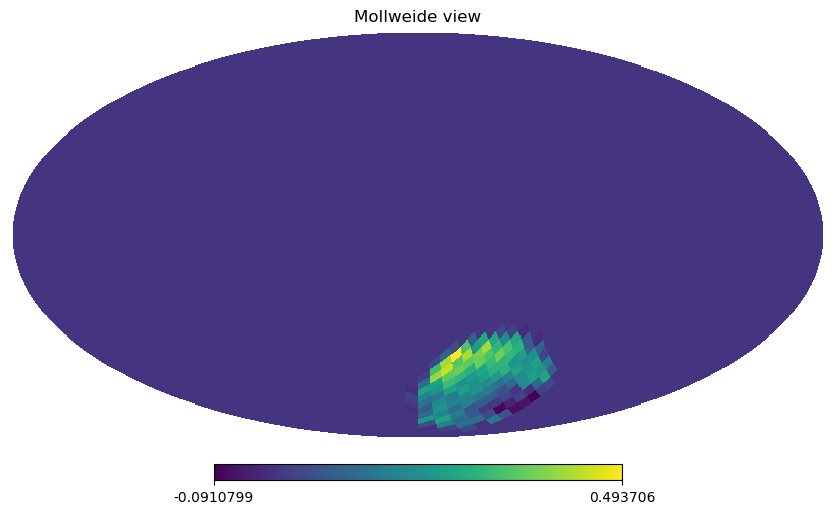

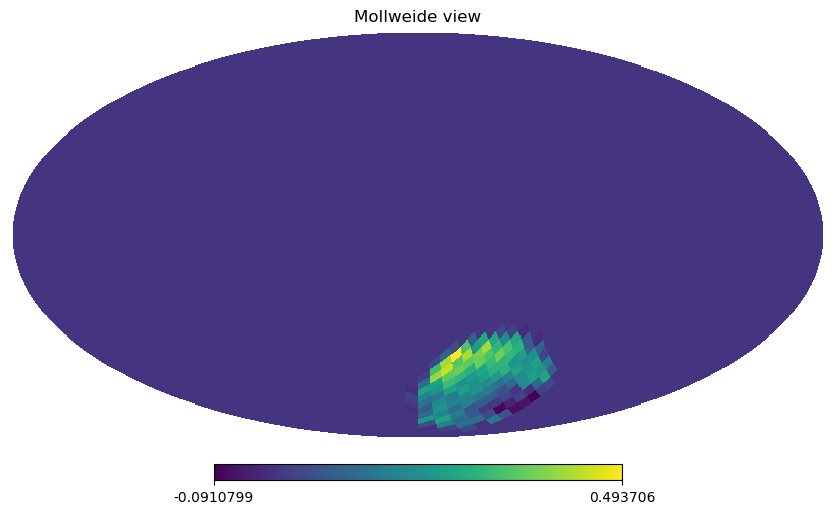

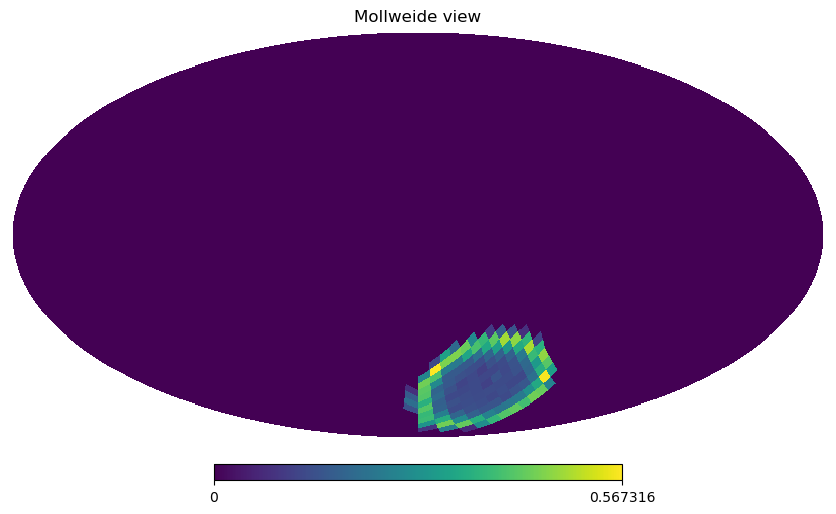

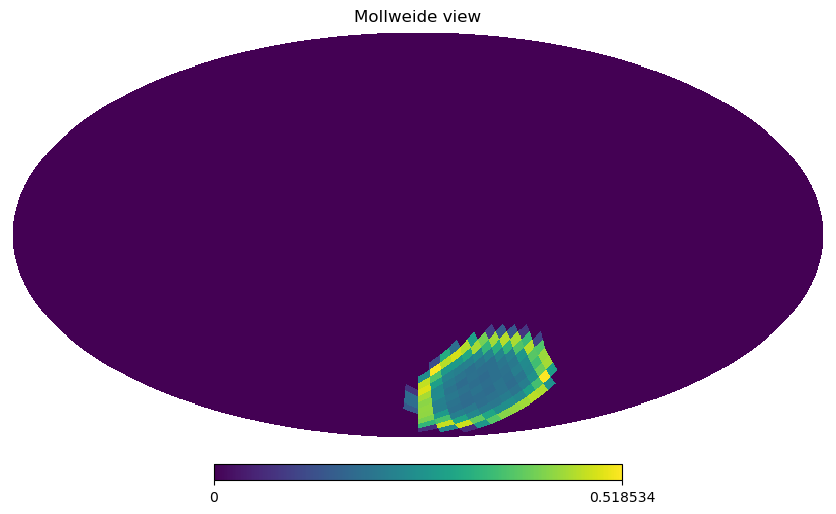

In [28]:
#Downgraded analysis for the full HFI case

nside_out = 16
npix_out = hp.nside2npix(nside_out)
ang_resolution = hp.nside2resol(nside_out, arcmin=True) / 60 # in deg
ratio_pixin_pixout = npix // npix_out

print(f'{ang_resolution} deg')
print(ratio_pixin_pixout)

avg_type = 'std'
dispersion = False

res_dg = hp.pixelfunc.ud_grade(masked_res, nside_out)
res_mean_dg = hp.pixelfunc.ud_grade(masked_mean_res, nside_out)
res_rms_dg = hp.pixelfunc.ud_grade(masked_res, nside_out, avg_type=avg_type, dispersion=dispersion)

hp.mollview(np.mean(res_dg,axis=0))
hp.mollview(res_mean_dg)

hp.mollview(np.std(res_dg,axis=0))
hp.mollview(np.mean(res_rms_dg,axis=0))


(99, 130)


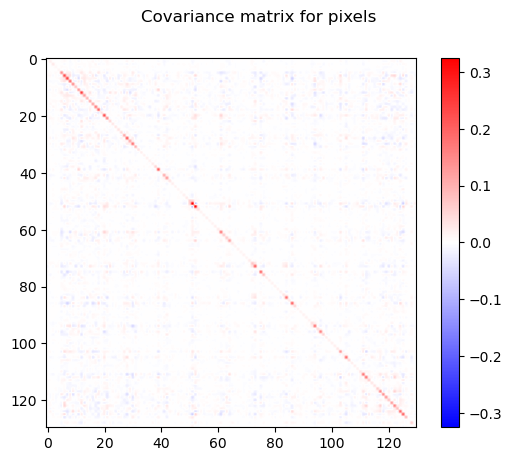

In [29]:
mask_dg = hp.pixelfunc.ud_grade(mask, nside_out)
seenpix_dg = np.array(mask_dg,dtype=bool)

res_dg_qubic = res_dg[:,seenpix_dg]
print(np.shape(res_dg_qubic))

cov = np.cov( res_dg_qubic, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for pixels')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

In [30]:
cov = np.cov( res_dg, rowvar = False )
cov = cov[seenpix_dg,:]
cov = cov[:,seenpix_dg]
print(np.shape(cov))

(130, 130)


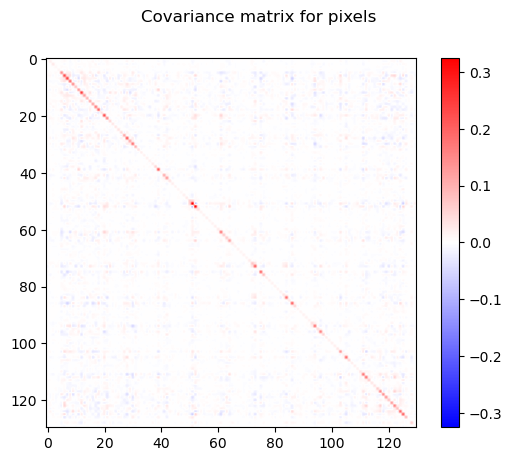

In [31]:
plt.figure()
plt.suptitle('Covariance matrix for pixels')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

(99, 2, 786432, 3)
(99, 2, 26381, 3)
(6, 6, 26381)


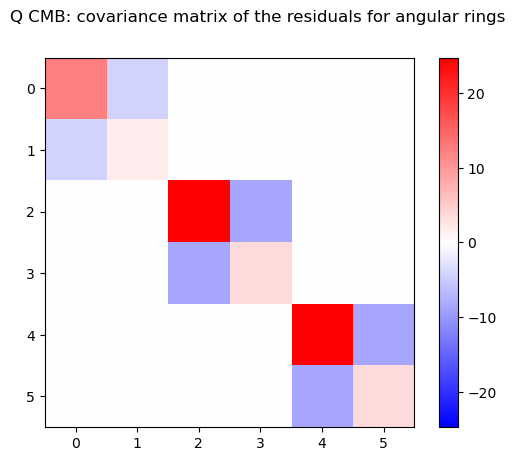

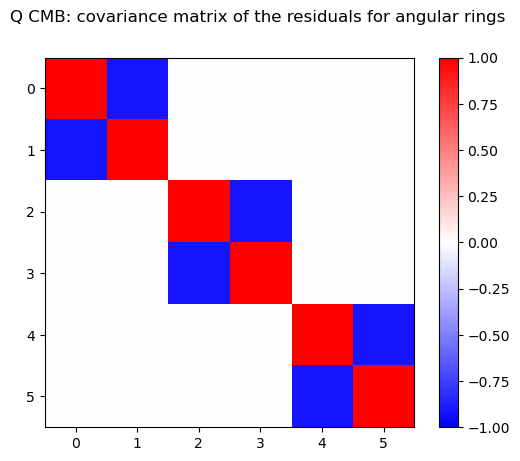

In [32]:
res_qubic = res[:,:,seenpix,:]
print(res.shape)
print(res_qubic.shape)

cov, corr = amc.get_covcorr_patch(res_qubic,stokesjoint=True)
print(cov.shape)
cov = np.mean(cov[:, :, :],axis=2)
corr = np.mean(corr[:, :, :],axis=2)
plt.figure()
plt.suptitle('Q CMB: covariance matrix of the residuals for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.figure()
plt.suptitle('Q CMB: covariance matrix of the residuals for angular rings')
vmax = np.max(np.abs(corr[:, :]))
plt.imshow(corr[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

(6, 6, 26381)


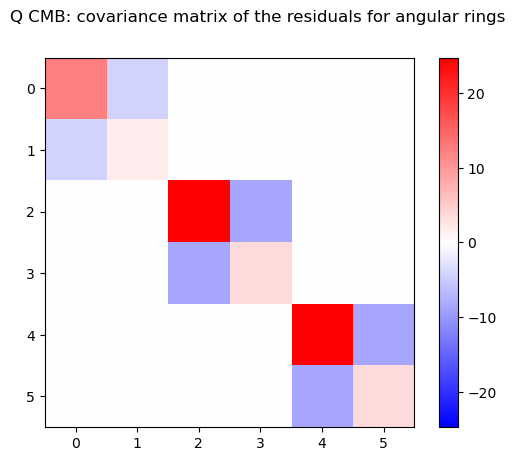

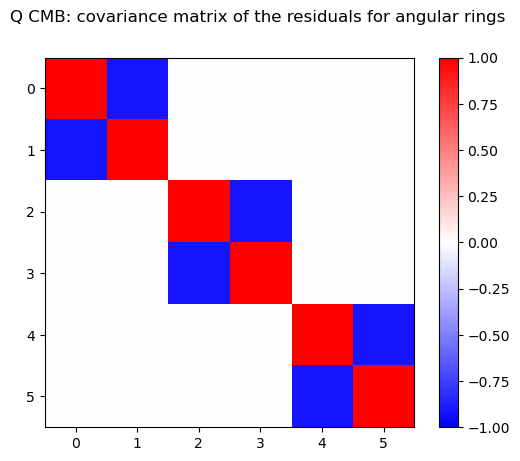

In [45]:
print(np.std(masked_res,axis=0).shape)

(786432,)


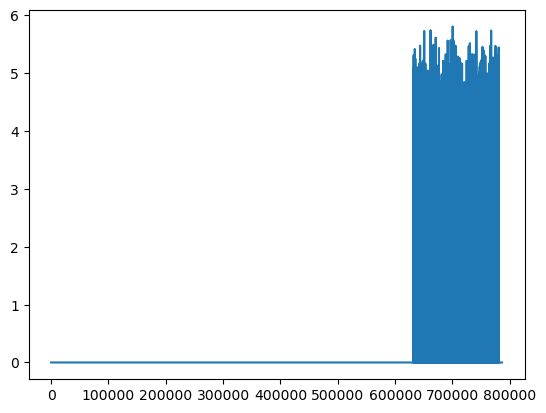

In [46]:
plt.figure()
plt.plot(np.std(masked_res,axis=0))

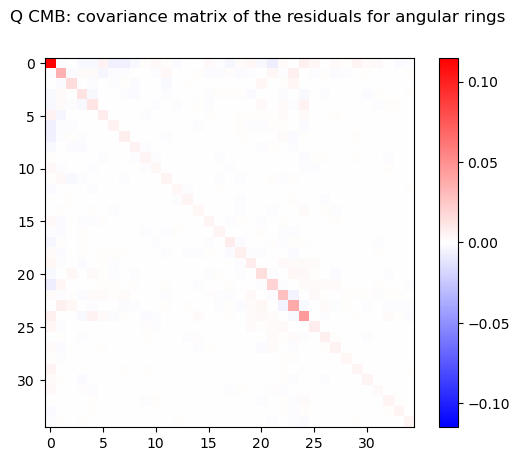

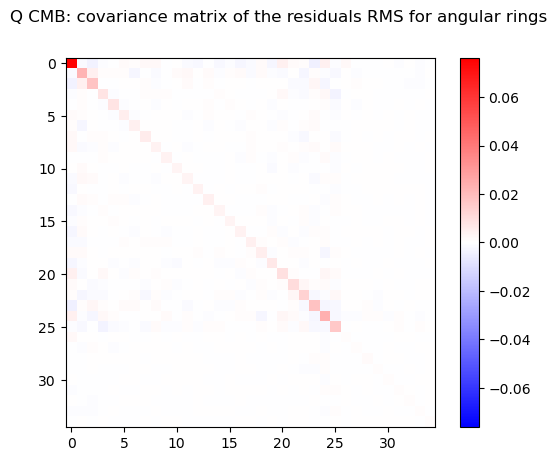

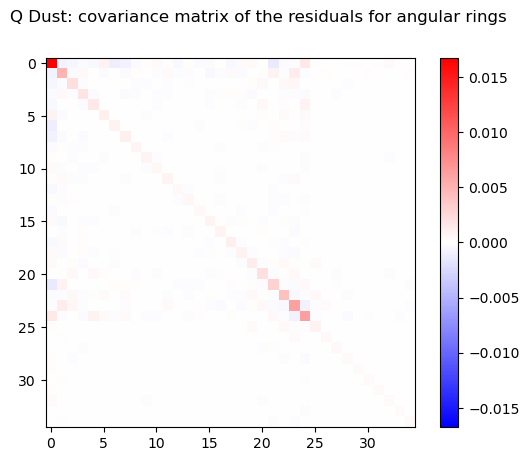

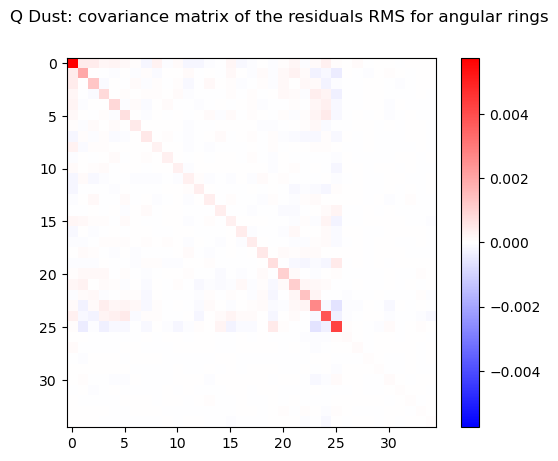

In [14]:
cov = np.cov( Q_cmb, rowvar = False )
plt.figure()
plt.suptitle('Q CMB: covariance matrix of the residuals for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dQ_cmb, rowvar = False )
plt.figure()
plt.suptitle('Q CMB: covariance matrix of the residuals RMS for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( Q_dust, rowvar = False )
plt.figure()
plt.suptitle('Q Dust: covariance matrix of the residuals for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dQ_dust, rowvar = False )
plt.figure()
plt.suptitle('Q Dust: covariance matrix of the residuals RMS for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

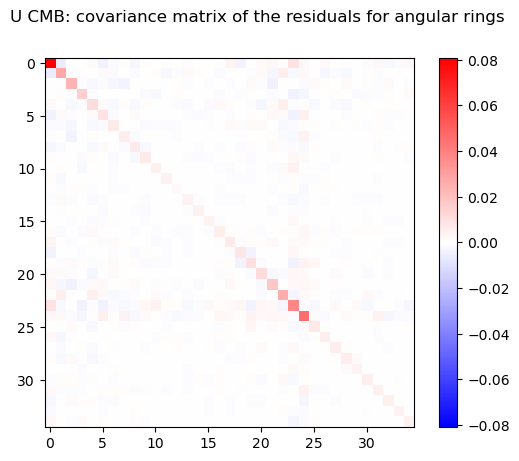

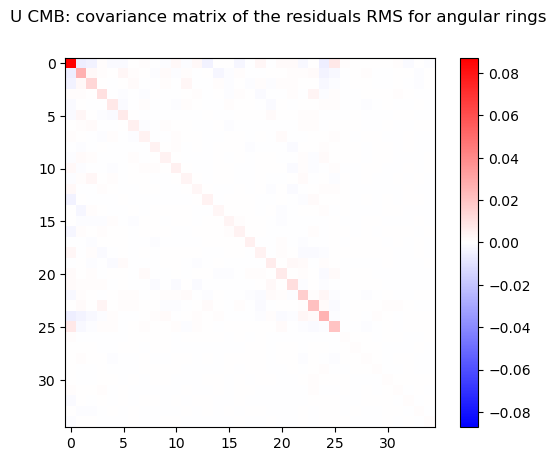

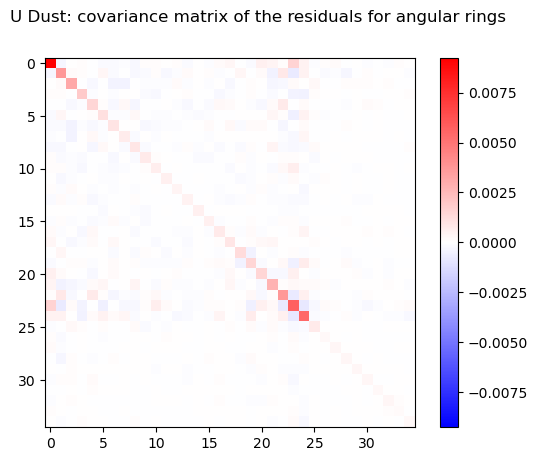

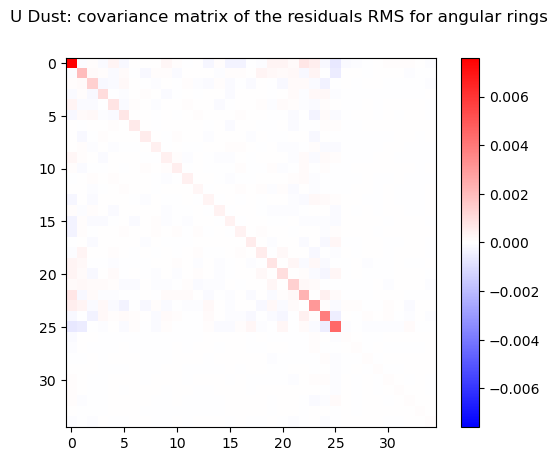

In [15]:
cov = np.cov( U_cmb, rowvar = False )
plt.figure()
plt.suptitle('U CMB: covariance matrix of the residuals for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_cmb, rowvar = False )
plt.figure()
plt.suptitle('U CMB: covariance matrix of the residuals RMS for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( U_dust, rowvar = False )
plt.figure()
plt.suptitle('U Dust: covariance matrix of the residuals for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_dust, rowvar = False )
plt.figure()
plt.suptitle('U Dust: covariance matrix of the residuals RMS for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

In [57]:
# rms_vs_iter_304470 = np.loadtxt('rms_vs_iter_304470.txt')
# plt.figure()
# plt.semilogy(rms_vs_iter_304470*100)
# plt.ylabel('% max rms variation wrt the last 20 iterations')
# plt.xlabel('Iteration')
# plt.grid()

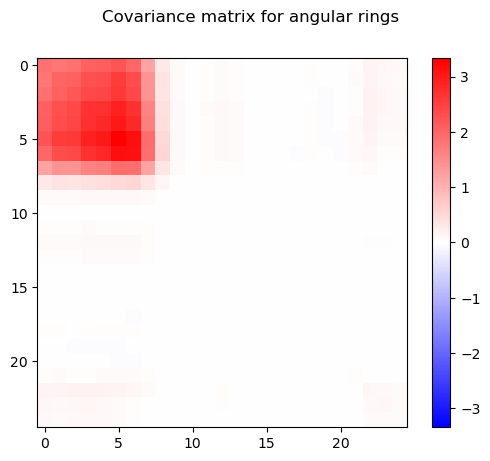

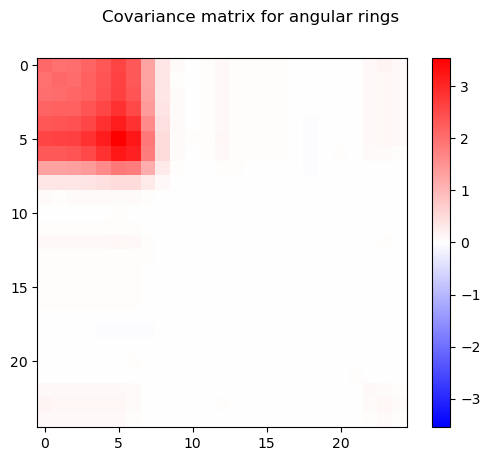

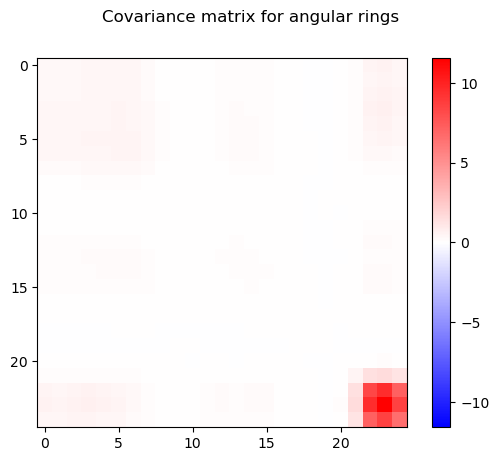

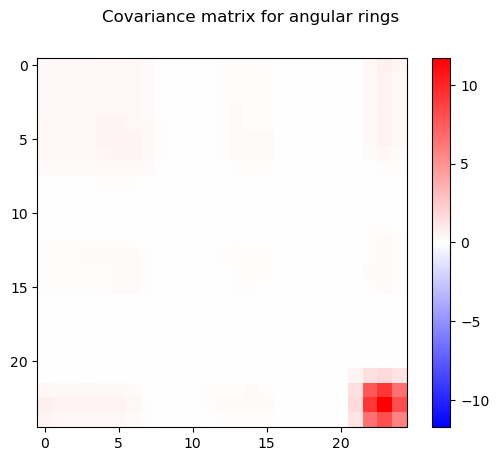

In [244]:
cov = np.cov( dQ_cmb, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_cmb, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dQ_dust, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_dust, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

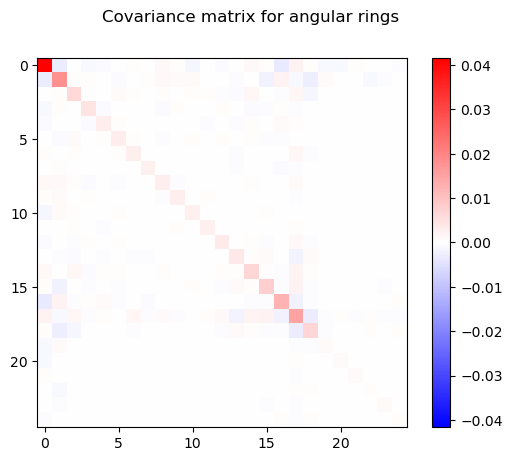

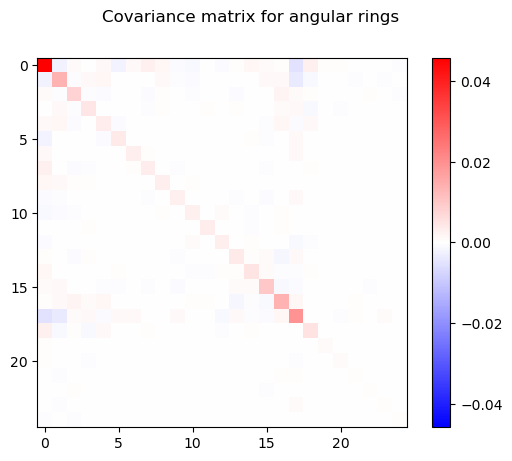

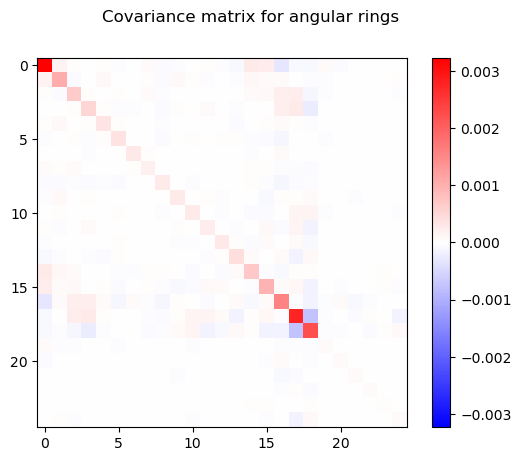

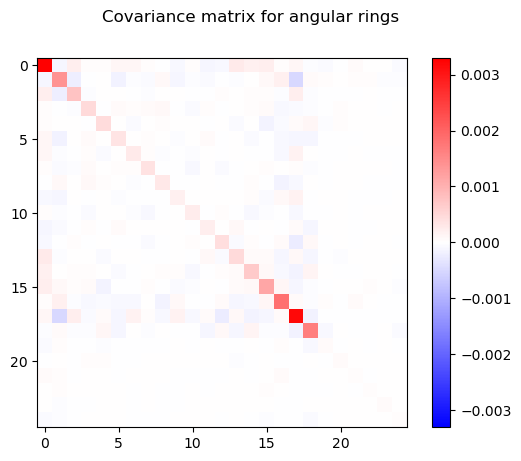

In [243]:
cov = np.cov( dQ_cmb_1, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_cmb_1, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dQ_dust_1, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

cov = np.cov( dU_dust_1, rowvar = False )
plt.figure()
plt.suptitle('Covariance matrix for angular rings')
vmax = np.max(np.abs(cov[:, :]))
plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()